# PPOL 565 Final Project Code
## Eric LaRose
## May 4, 2020

This file contains all the relevant code for my final project. My final project looks at county-level economic recovery since the Great Recession (over the period 2009-2016), and considers a wide range of demographic, economic, and policy variables that might plausibly explain economic performance. We consider three separate models of economic performance: percent changes in total employment, percent changes in median household income, and percent changes in the unemployment rate. Because these three measures are only weakly correlated with each other, it is important to model each of these variables separately (i.e., as separate dependent variables) to better understand economic performance. For each variable, a decision tree and ordinary least squares regression are used to determine which potential explanatory variables are the most important in determining county-level economic growth.

This Jupyter Notebook is divided intro three separate sections. The first imports the raw data and cleans it. The second does basic exploratory data analysis. The third and final section conducts the analyses.

In [1]:
# For basic data cleaning:
import pandas as pd

# For working with matrices and vectors:
import numpy as np

# To set working directory:
import os

# For summarizing results of linear regression:
import statsmodels.api as sm

# For estimating a linear regression model:
from sklearn.linear_model import LinearRegression

# For calculating mean squared error:
from sklearn.metrics import mean_squared_error

# For making plots:
import seaborn as sns
import matplotlib.pyplot as plt

# For creating summary tables of regression results:
from statsmodels.iolib.summary2 import summary_col

# To split data into training and test datasets:
from sklearn.model_selection import train_test_split

# For implementing a decision tree:
from sklearn import tree

# For plotting a decision tree:
from sklearn.tree import export_graphviz  

# For exporting a decision tree as a PDF:
import pydotplus

#os.chdir('/Users/ericlarose/Documents/Georgetown/DSPP/Spring_2020_Classes/Data_Science_II/Final_Project/')

# Part 1: Import and Clean Data

In this section, we import and clean raw data from the following sources:

1. The County Business Patterns (CBP) dataset provided by the U.S. Census Bureau. This data contains information on each county and industry in the U.S. within each year. This data is available here: https://www.census.gov/programs-surveys/cbp/data/datasets.html. 
2. The Local Area Unemployment Statistics (LAUS) dataset available from the Bureau of Labor Statistics. This data contains information on annual unemployment rates by county. This data is available here: 
https://www.bls.gov/lau/.
3. Data from the American Community Survey provided by the Census Bureau. While such data is available through the Census API, I downloaded this data from the National Historical Geographic Information System (NHGIS) because the NHGIS allows you to download all relevant variables at once, rather than needing to make a call to obtain one variable at a time. NHGIS data is available here: https://www.nhgis.org/.
4. Data on on county land area from the U.S. Gazetteer files provided by the Census Bureau. This information is used to calculate population density in each county. This data is available here: https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.2010.html.
5. Data on county- and state-level outcomes from the 2008 presidential election, provided by the MIT Election Lab. This information is used to calculated Obama's share of the vote for each county, and for each county's corresponding data. This data is available here:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ.
6. Data on state-level tax burdens provided by the Tax Foundation, available at:
https://taxfoundation.org/state-and-local-tax-burdens-historic-data/.

After importing and cleaning these datasets, we combine them to form a completed dataset with each observation corresponding to a county.

## 1. County Business Patterns Data

We import two CBP datasets, one corresponding to 2009 and one corresponding to 2016. Each dataset contains employment in each county-industry pair, where an industry is defined based on NAICS code classifications. From the CBP data we extract the following variables.

1. Total employment in each county in 2009 (independent variable)
2. Percentage change in employment in each county, 2009-2016 (one of our three dependent variables)
3. Manufacturing employment as a percent of the county's total employment in 2009 (independent variable)

The comments in the chunks of code below contain additional information on the cleaning steps. First, we calculate the first two variables above:

### Aggregate Employment

The two chunks of code below calculate total employment in each county in 2009 and the percentage change in employment from 2009-2016.

In [2]:
# Read in 2009 CBP data
CBP_2009_data = pd.read_csv('Raw_Data/CBP/cbp09co.txt')

# Read in 2016 CBP data
CBP_2016_data = pd.read_csv('Raw_Data/CBP/cbp16co.txt')

# The unit of observation in both years is a county-industry pair. A county is indicated by a two-digit
# state FIPS code, 'fipstate', and a three-digit county FIPS code, 'fipscty'.
# For each dataset, rename the 'emp' and 'empflag' variables to match the corresponding year, then merge 
# these two dataset on county and industry.
CBP_2009_data.rename(columns={'emp':'county_emp_2009', 'empflag' : 'empflag_2009'}, inplace = True)
CBP_2016_data.rename(columns={'emp':'county_emp_2016', 'empflag' : 'empflag_2016'}, inplace = True)
CBP_2009_2016_data = CBP_2009_data.merge(CBP_2016_data, how = 'inner', on = ['fipstate', 'fipscty', 'naics'])

# In this dataset the state and county FIPS codes are provided as separate variables, but we prefer to use the 
# five-digit county FIPS code (which is just the two-digit state and three-digit county codes concatenated).
# We combine these variables below.
CBP_2009_2016_data['county_fips'] = 1000*CBP_2009_2016_data.fipstate + \
    CBP_2009_2016_data.fipscty

# We want to keep only observations corresponding to aggregate county empoyment
# For pairs with small employment values,
# exact employment is often censored, but assigned corresponding bins as indicated in the 'empflag' variable.
# For instance, an empflag of 'A' means that employment is between 0 and 19. For these censored values, we assign
# employment as the midpoint of each bin, rounded up to the nearest whole number; for instance, an employment 
# flag of 'A' would be assigned employment of 10.

# First, we need to create a dictionary that maps the empflag with the midpoint of the corresponding employment
# bin. These bins are taken from: 
# https://www2.census.gov/programs-surveys/cbp/technical-documentation/records-layouts/noise-layout/county_layout.txt?#
CBP_bin_midpoint_dict = {'A' : 10,
                         'B' : 60,
                         'C' : 175,
                         'E' : 375,
                         'F' : 750,
                         'G' : 1750,
                         'H' : 3750,
                         'I' : 7500,
                         'J' : 17500,
                         'K' : 37500,
                         'L' : 75000,
                         'M' : 250000}

# Next, in the CBP data, replace censored employment values for 2009 and 2016 with the midpoints of corresponding
# bins using the 'map' function, then update the employment variable.
CBP_2009_2016_data['county_emp_imputed_2009'] = \
    CBP_2009_2016_data.empflag_2009.map(CBP_bin_midpoint_dict)
CBP_2009_2016_data['county_emp_imputed_2016'] = \
    CBP_2009_2016_data.empflag_2016.map(CBP_bin_midpoint_dict)
CBP_2009_2016_data.loc[~CBP_2009_2016_data.empflag_2009.isnull(),
                       'county_emp_2009'] = CBP_2009_2016_data.county_emp_imputed_2009
CBP_2009_2016_data.loc[~CBP_2009_2016_data.empflag_2016.isnull(),
                       'county_emp_2016'] = CBP_2009_2016_data.county_emp_imputed_2016

CBP_2009_2016_data.head(n = 5)


,fipstate,fipscty,naics,empflag_2009,emp_nf_x,county_emp_2009,qp1_nf_x,qp1_x,ap_nf_x,ap_x,...,n1000_y,n1000_1_y,n1000_2_y,n1000_3_y,n1000_4_y,censtate_y,cencty_y,county_fips,county_emp_imputed_2009,county_emp_imputed_2016
0,1,1,------,NaN,G,10628.0,G,66731,G,270567,...,0,0,0,0,0,63,1,1001,NaN,NaN
1,1,1,11----,NaN,H,31.0,H,193,H,960,...,0,0,0,0,0,63,1,1001,NaN,NaN
2,1,1,113///,NaN,H,25.0,H,154,H,799,...,0,0,0,0,0,63,1,1001,NaN,NaN
3,1,1,1133//,NaN,H,25.0,H,154,H,799,...,0,0,0,0,0,63,1,1001,NaN,NaN
4,1,1,11331/,NaN,H,25.0,H,154,H,799,...,0,0,0,0,0,63,1,1001,NaN,NaN


In [3]:
# Keep only observations corresponding to aggregate employment, which is indicated by no NAICS code 
# (as NAICS codes are used to denote specific industries, so the NAICS code '------' indicates aggregate
# county employment.) We create a new dataframe in this process.
CBP_aggregate_county_emp_2009_2016 = \
    CBP_2009_2016_data[CBP_2009_2016_data.naics=='------']

# Keep only variables we need - the county ID information and aggregate county employment in each year
CBP_aggregate_county_emp_2009_2016 = \
    CBP_aggregate_county_emp_2009_2016[['county_fips', 'county_emp_2009', 'county_emp_2016']]

# Next, calculate the percent change in employment from 2009-2016, by county
CBP_aggregate_county_emp_2009_2016['pct_chg_emp_2009_2016'] = \
    100*(CBP_aggregate_county_emp_2009_2016.county_emp_2016 - CBP_aggregate_county_emp_2009_2016.county_emp_2009)/(CBP_aggregate_county_emp_2009_2016.county_emp_2009)

# Keep only the three variables we need - county 5-digit FIPS code, county employment in 2009, and the county's
# percentage change in employment from 2009 through 2016.
county_emp_data = CBP_aggregate_county_emp_2009_2016[['county_fips', 'county_emp_2009', 'pct_chg_emp_2009_2016']]
county_emp_data.head(n = 5)


,county_fips,county_emp_2009,pct_chg_emp_2009_2016
0,1001,10628.0,1.524275
607,1003,52233.0,17.437252
1741,1005,7990.0,-14.180225
2199,1007,2927.0,15.715750
2659,1009,6968.0,-9.787600


### Manufacturing Employment

The chunk of code below calculates manufacturing employment as a percent of total employment in each county in 2009.

In [4]:
# Manufacturing corresponds to two-digit NAICS code 31. We can extract this from the 'CBP_2009_2016' dataframe
# created above.
CBP_manufacturing_emp_2009_data = CBP_2009_2016_data[(CBP_2009_2016_data.naics == '31----')]
CBP_manufacturing_emp_2009_data = CBP_manufacturing_emp_2009_data.copy()

# Create variable corresponding to five-digit county FIPS code
CBP_manufacturing_emp_2009_data['county_fips'] = 1000*CBP_manufacturing_emp_2009_data.fipstate + \
    CBP_manufacturing_emp_2009_data.fipscty

# Keep only the variables we need, county FIPS code and employment
CBP_manufacturing_emp_2009_data = CBP_manufacturing_emp_2009_data[['county_fips', 'county_emp_2009']]

# Rename employment variable as manufacturing employment specifically
CBP_manufacturing_emp_2009_data.rename(columns = {'county_emp_2009' : 'county_mfg_emp_2009'}, inplace = True)

# Merge this data on 2009 manufacturing employment with county-level data on aggregate employment
CBP_manufacturing_emp_2009_data = CBP_manufacturing_emp_2009_data.merge(CBP_aggregate_county_emp_2009_2016, \
                                                                        how = 'inner', on = ['county_fips'])
CBP_manufacturing_emp_2009_data = CBP_manufacturing_emp_2009_data[['county_fips', 'county_emp_2009', \
                                                                   'county_mfg_emp_2009']]

# Calculate manufacturing employment in 2009 as a percent of total employment in 2009.
CBP_manufacturing_emp_2009_data['county_pct_emp_mfg_2009'] = \
    100*CBP_manufacturing_emp_2009_data.county_mfg_emp_2009/CBP_manufacturing_emp_2009_data.county_emp_2009

# Keep only the county FIPS code and the percentage of employment in manufacturing
CBP_manufacturing_emp_2009_data = CBP_manufacturing_emp_2009_data[['county_fips', 'county_pct_emp_mfg_2009']]

CBP_manufacturing_emp_2009_data.head(n = 5)


,county_fips,county_pct_emp_mfg_2009
0,1001,16.465939
1,1003,7.523979
2,1005,47.008761
3,17079,21.331058
4,1007,13.016741


## 2. BLS Unemployment Data

We import two datasets from the Local Area Unemployment Statistics (LAUS) provided by the Bureau of Labor Statistics (BLS), one from 2009 and one from 2016. The unit of observation in each dataset is the county. From here we calculate the following variable:

1. Percentage change in each county's unemployment rate, 2009-2016 (one of our three dependent variables)
2. County's unemployment rate in 2009 (independent variable)

The chunk of code below calculates this, and the comments provide more explanation of the data cleaning steps.


In [5]:
# Read in BLS data from 2009 and 2016. The unit of observation is a county.
BLS_2009_data = pd.read_excel('Raw_Data/BLS/laucnty09.xlsx', skiprows = 5)
BLS_2016_data = pd.read_excel('Raw_Data/BLS/laucnty16.xlsx', skiprows = 5)

# Before we merge these two datasets, rename these variables to be year-specific. Documentation which contains
# the meaning of each variable can be accessed here: https://www.bls.gov/lau/publications.htm
# For each county, we keep information on the number of individuals in the labor force, and the number of 
# unemployed individuals. From here we can calculate unemployment rates.
BLS_2009_data = BLS_2009_data[['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6', 'Unnamed: 8']]
BLS_2009_data.columns = ['statefips', 'countyfips', 'county_labor_force_2009', 'county_unemployed_2009']
BLS_2016_data = BLS_2016_data[['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6', 'Unnamed: 8']]
BLS_2016_data.columns = ['statefips', 'countyfips', 'county_labor_force_2016', 'county_unemployed_2016']

# Now, merge these two datasets based on county and state FIPS codes
BLS_unemp_data = BLS_2009_data.merge(BLS_2016_data, how = 'inner', on = ['statefips', 'countyfips'])

# Drop any null values, which primarily correspond to counties outside of the 50 states and D.C. 
# (e.g., Puerto Rico)
BLS_unemp_data = BLS_unemp_data.dropna()

# Calculate five-digit county FIPS code
BLS_unemp_data['county_fips'] = 1000*BLS_unemp_data.statefips + BLS_2009_data.countyfips
BLS_unemp_data.county_fips = BLS_unemp_data.county_fips.astype(int)

# In both 2009 and 2016, calculate the county-level unemployment rate
BLS_unemp_data['county_unemp_rate_2009'] = 100 * \
    (BLS_unemp_data.county_unemployed_2009/BLS_unemp_data.county_labor_force_2009)
BLS_unemp_data['county_unemp_rate_2016'] = 100 * \
    (BLS_unemp_data.county_unemployed_2016/BLS_unemp_data.county_labor_force_2016)

# Calculate the percentage change in the county's unemployment rate, 2009-2016
BLS_unemp_data['pct_chg_cty_unemp_rate_2009_2016'] = 100 * \
    (BLS_unemp_data.county_unemp_rate_2016 - BLS_unemp_data.county_unemp_rate_2009)/ \
    (BLS_unemp_data.county_unemp_rate_2009)

# Keep only the three variables we need: county FIPS code, change in the unemployment rate, and unemployment
# rate in 2009
BLS_unemp_data = BLS_unemp_data[['county_fips', 'county_unemp_rate_2009', 'pct_chg_cty_unemp_rate_2009_2016']]

BLS_unemp_data.head(n = 5)

,county_fips,county_unemp_rate_2009,pct_chg_cty_unemp_rate_2009_2016
0,1001,9.723515,-47.679190
1,1003,9.760949,-45.413986
2,1005,14.305708,-41.865847
3,1007,13.280714,-51.449357
4,1009,10.000000,-46.188523


## 3. American Community Survey Data

This American Community Survey is downloaded from the NHGIS, described in more detail above. We import two data files. One is from 2009 (the 2007-2011 5-year ACS), and the other is from 2016 (the 2014-2018 5-year ACS). The unit of observation in each data file is a county. From this data, we extract the following variables:

1. The county's population in 2009 (independent variable)
2. The county's median household income, in dollars, in 2009 (independent variable)
3. The percent of the population in poverty in the county in 2009 (independent variable)
4. The percent of the population aged 25+ with at least a bachelor's degree in the county in 2009 (independent variable)
5. The percent change in the county's median household income, 2009-2016 (one of our three dependent variables)

The comments in the chunks of code below contain additional information on the cleaning steps. 

In [6]:
## This chunk of code loads in and cleans the 2007-2011 5-year ACS data.

# Read in 2009 (2007-2011) ACS data, downloaded from the NHGIS. The unit of observation is a county, and this 
# contains information on a wide variety of variables. The codebook with information on variable names is 
# provided in the same subfolder from which the data is loaded.
ACS_2009_data = pd.read_csv('Raw_Data/2007_2011_ACS/nhgis0012_csv/nhgis0012_ds184_20115_2011_county.csv', 
                            encoding='ISO-8859-1')
# Keep only relevant information needed to calculate our variables of interest
ACS_2009_data = ACS_2009_data[['COUNTY', 'STATE', 'STATEA', 'COUNTYA', 'MNTE001', 
                               'MPSE001', 'MPSE015', 'MPSE016', 'MPSE017', 'MPSE018', 
                               'MPSE032', 'MPSE033', 'MPSE034', 'MPSE035', 'MPVE001', 
                               'MPVE002', 'MPVE003', 'MP1E001']]
# Rename columns
ACS_2009_data.columns = ['county_name', 'state_name', 'state_fips', 'countyfips', 
                         'county_pop_2009', 'county_pop_25_over', 'male_pop_bachelors', 
                         'male_pop_masters', 'male_pop_professional', 'male_pop_phd', 
                         'female_pop_bachelors', 'female_pop_masters', 'female_pop_professional', 
                         'female_pop_phd', 'total_pop_poverty_det', 'total_pop_under_half_poverty', 
                         'total_pop_half_to_poverty', 'county_median_hh_inc_2009']

# Using the educational status variables, calculate the percent of the population age 25 or over with at least a
# bachelor's degree in each county in 2009
ACS_2009_data['county_pct_pop_25_over_w_bachelors_or_higher_2009'] = \
    100*(ACS_2009_data.male_pop_bachelors + ACS_2009_data.male_pop_masters + \
         ACS_2009_data.male_pop_professional + ACS_2009_data.male_pop_phd + \
         ACS_2009_data.female_pop_bachelors + ACS_2009_data.female_pop_masters + \
         ACS_2009_data.female_pop_professional + ACS_2009_data.female_pop_phd)/(ACS_2009_data.county_pop_25_over)

# Using the variables on income relative to the poverty level, calculate the percent of the population living 
# below the poverty line in 2009.
ACS_2009_data['county_pct_pop_in_poverty_2009'] = 100*(ACS_2009_data.total_pop_under_half_poverty + \
                                                  ACS_2009_data.total_pop_half_to_poverty\
                                                 )/(ACS_2009_data.total_pop_poverty_det)

# Keep only the variables we need from this dataset.
ACS_2009_data = ACS_2009_data[['countyfips', 'county_name', 'state_name', 'state_fips', 
                               'county_pop_2009', 'county_median_hh_inc_2009', 
                               'county_pct_pop_in_poverty_2009', 
                               'county_pct_pop_25_over_w_bachelors_or_higher_2009']]

ACS_2009_data.head(n = 5)


,countyfips,county_name,state_name,state_fips,county_pop_2009,county_median_hh_inc_2009,county_pct_pop_in_poverty_2009,county_pct_pop_25_over_w_bachelors_or_higher_2009
0,1,Autauga County,Alabama,1,53944,53899,10.878692,21.624592
1,3,Baldwin County,Alabama,1,179523,51321,12.467343,27.214946
2,5,Barbour County,Alabama,1,27546,34041,24.717594,13.897696
3,7,Bibb County,Alabama,1,22746,40506,15.654894,9.809692
4,9,Blount County,Alabama,1,57140,45404,13.708269,11.298833


In [7]:
## This chunk of code loads in and cleans the 2014-2018 5-year ACS data.

# Read in 2016 (2014-2018) ACS data, downloaded from the NHGIS. The unit of observation is a county, and this 
# contains information on a wide variety of variables. The codebook with information on variable names is 
# provided in the same subfolder from which the data is loaded. The only information of interest from this
# dataset is on median household income in 2016.
ACS_2016_data = pd.read_csv('Raw_Data/2014_2018_ACS/nhgis0013_csv/nhgis0013_ds239_20185_2018_county.csv', 
                            encoding='ISO-8859-1')
# Keep only relevant information needed to calculate our variables of interest
ACS_2016_data = ACS_2016_data[['STATEA', 'COUNTYA', 'AJZAE001']]
# Rename columns
ACS_2016_data.columns = ['state_fips', 'countyfips', 'county_median_hh_inc_2016']

ACS_2016_data.head(n = 5)


,state_fips,countyfips,county_median_hh_inc_2016
0,1,1,58786.0
1,1,3,55962.0
2,1,5,34186.0
3,1,7,45340.0
4,1,9,48695.0


In [8]:
## This chunk of code merges the 2009 and 2016 ACS data and does some final cleaning steps.

# Merge 2009 and 2016 ACS data together based on county and state FIPS codes
ACS_data = ACS_2009_data.merge(ACS_2016_data, how = 'inner', on = ['state_fips', 'countyfips'])

# Calculate five-digit county FIPS code
ACS_data['county_fips'] = 1000*ACS_data.state_fips + ACS_data.countyfips

# Calculate percent change in median household income between 2009 and 2016
ACS_data['pct_change_median_hh_inc_2009_2016'] = 100*(ACS_data.county_median_hh_inc_2016 - ACS_data.county_median_hh_inc_2009)/(ACS_data.county_median_hh_inc_2009)

# Drop variables for county three-digit FIPS code and median household income in 2016
ACS_data = ACS_data.drop(columns=['county_median_hh_inc_2016', 'countyfips'])

# Drop Puerto Rico and U.S. territories
ACS_data = ACS_data[ACS_data.state_fips<=56]

ACS_data.head(n = 5)


,county_name,state_name,state_fips,county_pop_2009,county_median_hh_inc_2009,county_pct_pop_in_poverty_2009,county_pct_pop_25_over_w_bachelors_or_higher_2009,county_fips,pct_change_median_hh_inc_2009_2016
0,Autauga County,Alabama,1,53944,53899,10.878692,21.624592,1001,9.066959
1,Baldwin County,Alabama,1,179523,51321,12.467343,27.214946,1003,9.043082
2,Barbour County,Alabama,1,27546,34041,24.717594,13.897696,1005,0.425957
3,Bibb County,Alabama,1,22746,40506,15.654894,9.809692,1007,11.934034
4,Blount County,Alabama,1,57140,45404,13.708269,11.298833,1009,7.248260


## 4. U.S. Gazetteer Data
This file contains information on land area by county, from the U.S. Gazetteer files provided by the Census Bureau. The unit of observation is a county, and the data comes from the 2010 Census. This information is used to calculate population density once we have merge all of our datasets.

The chunk of code below loads the data and creates a dataframe with county FIPS codes and each county's land area.

In [9]:
# Import U.S. Gazetteer 2010 file on county land area
county_land_area_data = pd.read_csv('Raw_Data/US_Gazetteer/Gaz_counties_national.txt', 
                                    encoding='ISO-8859-1', delimiter = '\t')

# Keep only the two variables we need, the county FIPS code and land area (in square miles)
county_land_area_data = county_land_area_data[['GEOID', 'ALAND_SQMI']]
county_land_area_data.rename(columns={'GEOID':'county_fips', 'ALAND_SQMI':'county_land_area_sq_mi'}, 
                             inplace = True)

county_land_area_data.head(n = 5)

,county_fips,county_land_area_sq_mi
0,1001,594.436
1,1003,1589.784
2,1005,884.876
3,1007,622.582
4,1009,644.776


## 5. MIT Election Lab Data
From the MIT Election Lab we import two data files, one contains county-level results from presidential elections and one contains state-level results. From here we calculate the following two variables:

1. The percent of the county's votes for Obama in the 2008 presidential election (independent variable)
2. The percent of each state's votes for Obama in the 2008 presidential election (independent variable)

The information on county-level results is from: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ. The information on state-level results is from:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX.

In [10]:
## This chunk of code reads in and cleans the county-level data. 

# Load in county-level data. The unit of observation is a county-year-candidate. For instance, in Autauga County,
# AL, there are four observations for 2000, one corresponding to votes for Al Gore, one for George Bush, one for
# Ralph Nader, and one for all other candidates. The variable 'candidatevotes' contains the number of votes for
# the given candidate, while the variable 'totalvotes' contains the number of votes for all candidates in that 
# county in that year. This file contains information on the presidential elections from 2000-2016, inclusive.
county_2008_election_results = pd.read_csv('Raw_Data/Pres_Election_2008_Results/countypres_2000-2016.csv')

# Keep only observations corresponding to votes for Obama in the 2008 presidential election.
county_2008_election_results = county_2008_election_results[(county_2008_election_results.candidate ==
                                                             'Barack Obama') & 
                                                            (county_2008_election_results.year==2008)]

# Calculate votes for Obama as a percentage of total votes for presidential candidates in that county
county_2008_election_results['pct_county_votes_Obama_2008'] = 100*\
    (county_2008_election_results.candidatevotes/county_2008_election_results.totalvotes)

# Keep only variables we need - the five-digit county FIPS code and the percent of votes for Obama
county_2008_election_results = county_2008_election_results[['FIPS', 'pct_county_votes_Obama_2008']]
county_2008_election_results.rename(columns={'FIPS':'county_fips'}, inplace = True)

# Drop any missing values
county_2008_election_results = county_2008_election_results.dropna()
county_2008_election_results.county_fips = county_2008_election_results.county_fips.astype(int)

county_2008_election_results.head(n = 5)

,county_fips,pct_county_votes_Obama_2008
21815,1001,25.773021
21818,1003,23.811922
21821,1005,48.985383
21824,1007,26.596483
21827,1009,14.513537


In [11]:
## This chunk of code reads in and cleans the state-level data.

# Load in state-level data. The unit of observation is a state-year-candidate. The structure overall is 
# analogous to that of the county-level data file.
state_2008_election_results = pd.read_csv('Raw_Data/Pres_Election_2008_Results/1976-2016-president.csv')

# Keep only observations corresponding to votes for Obama in the 2008 presidential election.
state_2008_election_results = state_2008_election_results[(state_2008_election_results.candidate ==
                                                             'Obama, Barack H.') & 
                                                            (state_2008_election_results.year==2008)]

# Calculate votes for Obama as a percentage of total votes for presidential candidates in that state
state_2008_election_results['pct_state_votes_Obama_2008'] = 100*\
    (state_2008_election_results.candidatevotes/state_2008_election_results.totalvotes)

# Keep only variables we need - the two-digit state FIPS code and the percent of votes for Obama
state_2008_election_results = state_2008_election_results[['state_fips', 'pct_state_votes_Obama_2008']]

# Drop any missing values
state_2008_election_results = state_2008_election_results.dropna()

state_2008_election_results.head(n = 5)

,state_fips,pct_state_votes_Obama_2008
2729,1,38.740434
2733,2,37.889374
2739,4,45.115251
2745,5,38.864660
2751,6,61.012638


## 6. Tax Foundation Data
From the Tax Foundation we import a data file on state-level tax burdens in 2009. The file calculates the average per capita taxes paid to the state, as a percentage of average income per capita. This data is downloaded from https://taxfoundation.org/state-and-local-tax-burdens-historic-data.

From here we calculate the following variable:

1. Average state taxes paid as percent of average income by state (independent variable)

In [12]:
## This chunk of code reads in and cleans the state-level data on tax burdens from the Tax Foundation. 

# Read in the csv file. The unit of observation is a state.
state_2009_tax_burdens = pd.read_csv('Raw_Data/Tax_Foundation/Tax_Foundation_2009_State_Burdens.csv')

# Keep only the two variables we need - the state name and the tax burden rate
state_2009_tax_burdens = state_2009_tax_burdens[['State', 'Burden Rate']]
state_2009_tax_burdens.rename(columns={'State':'state_name', 'Burden Rate' : 'state_tax_burden_rate_2009'}, inplace = True)

# The tax burden variable is currently as a string, which contains the percentage symbol (%). We want to remove
# this symbol, then convert the variable to a float.
state_2009_tax_burdens['state_tax_burden_rate_2009'] = \
    state_2009_tax_burdens['state_tax_burden_rate_2009'].str.replace(r'%', '').astype(float)

state_2009_tax_burdens.head(n = 5)


,state_name,state_tax_burden_rate_2009
0,Alabama,9.1
1,Alaska,7.0
2,Arizona,9.0
3,Arkansas,10.5
4,California,11.4


## Merge All Data Together

The chunk of code below merges together all the data created above. After doing so, it calculates the following variable:

1. Population density (people per square mile) by county in 2009 (independent variable)

Additionally, the chunk of code drops some irrelevant variables and then keeps only counties with a population of at least 25,000 in 2009. The reason for keeping only these counties is described in detail in the main report.

In [13]:
## This chunk of code, and the following chunks, merge together all the datasets created above and compile
## a final cleaned dataset.

# Use the ACS data as our "base" dataset, and merge with CBP data on county aggregate employment.
county_dataset = ACS_data.merge(county_emp_data, how = 'inner', on = ['county_fips'])

# Loop over the other county-level files to merge with the 'county_dataset' dataframe.
county_dataset_names = ['CBP_manufacturing_emp_2009_data', 'BLS_unemp_data', 'county_land_area_data', 
                        'county_2008_election_results']
for county_dataframe in county_dataset_names:
    county_dataset = county_dataset.merge(eval(county_dataframe), how = 'inner', on = ['county_fips'])

# Next, merge with the two state-level files on tax burdens and election results
county_dataset = county_dataset.merge(state_2008_election_results, how = 'inner', on = ['state_fips'])
county_dataset = county_dataset.merge(state_2009_tax_burdens, how = 'inner', on = ['state_name'])

# View the head of the resulting dataset
county_dataset.head(n = 5)

,county_name,state_name,state_fips,county_pop_2009,county_median_hh_inc_2009,county_pct_pop_in_poverty_2009,county_pct_pop_25_over_w_bachelors_or_higher_2009,county_fips,pct_change_median_hh_inc_2009_2016,county_emp_2009,pct_chg_emp_2009_2016,county_pct_emp_mfg_2009,county_unemp_rate_2009,pct_chg_cty_unemp_rate_2009_2016,county_land_area_sq_mi,pct_county_votes_Obama_2008,pct_state_votes_Obama_2008,state_tax_burden_rate_2009
0,Autauga County,Alabama,1,53944,53899,10.878692,21.624592,1001,9.066959,10628.0,1.524275,16.465939,9.723515,-47.679190,594.436,25.773021,38.740434,9.1
1,Baldwin County,Alabama,1,179523,51321,12.467343,27.214946,1003,9.043082,52233.0,17.437252,7.523979,9.760949,-45.413986,1589.784,23.811922,38.740434,9.1
2,Barbour County,Alabama,1,27546,34041,24.717594,13.897696,1005,0.425957,7990.0,-14.180225,47.008761,14.305708,-41.865847,884.876,48.985383,38.740434,9.1
3,Bibb County,Alabama,1,22746,40506,15.654894,9.809692,1007,11.934034,2927.0,15.715750,13.016741,13.280714,-51.449357,622.582,26.596483,38.740434,9.1
4,Blount County,Alabama,1,57140,45404,13.708269,11.298833,1009,7.248260,6968.0,-9.787600,20.077497,10.000000,-46.188523,644.776,14.513537,38.740434,9.1


In [14]:
# Calculate each county's population density per square mile in 2009
county_dataset['county_pop_density_2009'] = \
    (county_dataset.county_pop_2009)/(county_dataset.county_land_area_sq_mi)

# Drop land area per square mile
county_dataset = county_dataset.drop(columns=['county_land_area_sq_mi'])


In [15]:
# Keep only counties with at least 25,000 people
county_dataset = county_dataset[county_dataset.county_pop_2009>=25000]
county_dataset.shape

(1605, 18)

From above, we can see that there are 1,605 counties in our dataset once we exclude counties with fewer than 25,000 residents. Next, we evaluate and drop any missing values.

In [16]:
# Look at number of missing values for each table
print(county_dataset.isna().sum())

county_name                                          0
state_name                                           0
state_fips                                           0
county_pop_2009                                      0
county_median_hh_inc_2009                            0
county_pct_pop_in_poverty_2009                       0
county_pct_pop_25_over_w_bachelors_or_higher_2009    0
county_fips                                          0
pct_change_median_hh_inc_2009_2016                   2
county_emp_2009                                      0
pct_chg_emp_2009_2016                                0
county_pct_emp_mfg_2009                              0
county_unemp_rate_2009                               0
pct_chg_cty_unemp_rate_2009_2016                     0
pct_county_votes_Obama_2008                          0
pct_state_votes_Obama_2008                           0
state_tax_burden_rate_2009                           0
county_pop_density_2009                              0
dtype: int

In [17]:
# There are two NA values on percent change in median household income, drop these observations for now
county_dataset = county_dataset.dropna()

Finally, we save this intermediate dataset.

In [18]:
# Write 'county_dataset' dataframe to intermediate dataset
county_dataset.to_csv('Intermediate_Data/county_dataset.csv')

# Part 2: Exploratory Analysis

In this section, we conduct exploratory analysis of the data. First, we look at the distribution and summary statistics of all our variables, and take logs of variables that appear to be highly right-tail skewed. Second, we look at the correlations of our three dependent variables.

The chunk of code below looks at summary statistics for each variable in our dataset:

In [19]:
# Look at summary statistics for each numeric (non-ID) variable in our dataset
county_dataset.drop(columns=['state_fips', 'county_fips']).describe().round(2)

,county_pop_2009,county_median_hh_inc_2009,county_pct_pop_in_poverty_2009,county_pct_pop_25_over_w_bachelors_or_higher_2009,pct_change_median_hh_inc_2009_2016,county_emp_2009,pct_chg_emp_2009_2016,county_pct_emp_mfg_2009,county_unemp_rate_2009,pct_chg_cty_unemp_rate_2009_2016,pct_county_votes_Obama_2008,pct_state_votes_Obama_2008,state_tax_burden_rate_2009,county_pop_density_2009
count,1603.00,1603.00,1603.00,1603.00,1603.00,1603.00,1603.00,1603.00,1603.00,1603.00,1603.00,1603.00,1603.00,1603.00
mean,187247.81,48830.23,15.17,22.27,13.33,71864.35,5.82,15.70,9.56,-41.20,44.70,48.03,10.04,643.17
std,432919.84,12802.09,5.57,9.65,6.23,196968.25,10.89,10.47,3.04,17.47,12.98,11.75,1.22,4026.46
min,25069.00,22353.00,3.45,7.19,-16.20,1047.00,-56.12,0.27,2.55,-80.55,12.46,2.07,7.00,2.42
25%,39041.50,40466.00,11.37,15.03,9.60,10266.50,-0.36,7.68,7.47,-53.29,35.40,43.00,9.30,59.01
50%,64999.00,45992.00,14.85,19.67,13.03,18493.00,5.30,13.40,9.14,-43.66,44.09,49.95,10.00,107.76
75%,156008.00,53894.00,18.27,27.35,16.96,49240.50,10.99,21.55,11.32,-33.42,53.18,55.15,10.50,277.07
max,9787747.00,120096.00,40.38,70.66,43.33,3703233.00,81.80,68.34,27.37,45.59,92.46,92.46,12.80,69571.90


From the output above, we can see that the variables corresponding to population in 2009, employment in 2009, and population density in 2009 appear to be highly right-tail skewed, in that their means are far greater than their medians. We need to take logs of each of these variables so that they are roughly normally distributed. All other variables appear to be roughly normally distributed, with the means close to their medians.

In [20]:
# Take logs of employment in 2009, population in 2009, and population density in 2009. Drop the non-logged
# versions of these variables.
for var_name in ['county_pop_2009', 'county_emp_2009', 'county_pop_density_2009']:
    log_var_name = 'log_' + var_name
    county_dataset[log_var_name] = np.log(county_dataset.eval(var_name))
    county_dataset = county_dataset.drop([var_name], axis = 1)

# Describe these variables to see if they're normally distributed
print(county_dataset[['log_county_pop_2009', 'log_county_emp_2009', 'log_county_pop_density_2009']].describe())


       log_county_pop_2009  log_county_emp_2009  log_county_pop_density_2009
count          1603.000000          1603.000000                  1603.000000
mean             11.380356            10.139355                     4.919711
std               1.042322             1.240346                     1.325811
min              10.129387             6.953684                     0.884943
25%              10.572380             9.236641                     4.077665
50%              11.082127             9.825148                     4.679888
75%              11.957662            10.804471                     5.624266
max              16.096642            15.124717                    11.150116


From the output above, we can see that these logged variables appear to be normally distributed, as the means are very close to the medians. In the analysis below, we will use these three variables in logs, rather than levels.

Next, let's rename all of our variables to have "common names" that will look nice in all the plots and charts we present. Then, let's look at the correlations of each of our independent variables of interest.

In [21]:
# Rename variables to have "clean" names for ease of presentation in charts and plots
county_dataset.rename(columns={'county_name' : 'County', 'state_name' : 'State', 'state_fips' : 'State FIPS Code',
                               'county_median_hh_inc_2009' : 'Median Household Income ($)', 
                               'county_pct_pop_in_poverty_2009' : 'Poverty Rate (%)',
                               'county_pct_pop_25_over_w_bachelors_or_higher_2009' : 'Pop. w/ College Degree (%)',
                               'county_fips' : 'County FIPS Code', 
                               'pct_change_median_hh_inc_2009_2016' : 'Change in Median HH Income (%)',
                               'pct_chg_emp_2009_2016' : 'Change in Employment (%)',
                               'county_pct_emp_mfg_2009' : 'Share of Employment in Manufacturing (%)',
                               'pct_chg_cty_unemp_rate_2009_2016' : 'Change in Unemp. Rate (%)',
                               'pct_county_votes_Obama_2008' : 'Percent of Votes for Obama in 2008',
                               'pct_state_votes_Obama_2008' : "Percent of State's Votes for Obama in 2008",
                               'state_tax_burden_rate_2009' : "State's Tax Burden Rate",
                               'log_county_pop_2009' : 'Log(County Population)',
                               'log_county_emp_2009' : 'Log(County Employment)',
                               'log_county_pop_density_2009' : 'Log(County Population Density)',
                               'county_unemp_rate_2009' : 'Unemployment Rate (%)'},
                      inplace = True)
# Display correlations of all independent variables.
county_dataset.drop(['County FIPS Code', 'State FIPS Code', 'Change in Median HH Income (%)',
                     'Change in Employment (%)', 'Change in Unemp. Rate (%)'], 
                    axis = 1).corr().round(2)


,Median Household Income ($),Poverty Rate (%),Pop. w/ College Degree (%),Share of Employment in Manufacturing (%),Unemployment Rate (%),Percent of Votes for Obama in 2008,Percent of State's Votes for Obama in 2008,State's Tax Burden Rate,Log(County Population),Log(County Employment),Log(County Population Density)
Median Household Income ($),1.00,-0.79,0.69,-0.26,-0.13,0.16,0.14,0.28,0.46,0.45,0.45
Poverty Rate (%),-0.79,1.00,-0.40,0.07,0.14,0.05,-0.14,-0.27,-0.22,-0.23,-0.22
Pop. w/ College Degree (%),0.69,-0.40,1.00,-0.42,-0.14,0.41,0.08,0.21,0.57,0.63,0.55
Share of Employment in Manufacturing (%),-0.26,0.07,-0.42,1.00,0.16,-0.24,-0.02,-0.06,-0.38,-0.34,-0.23
Unemployment Rate (%),-0.13,0.14,-0.14,0.16,1.00,0.01,0.13,-0.03,0.01,-0.03,0.04
Percent of Votes for Obama in 2008,0.16,0.05,0.41,-0.24,0.01,1.00,0.22,0.40,0.43,0.45,0.42
Percent of State's Votes for Obama in 2008,0.14,-0.14,0.08,-0.02,0.13,0.22,1.00,0.03,0.07,0.07,0.04
State's Tax Burden Rate,0.28,-0.27,0.21,-0.06,-0.03,0.40,0.03,1.00,0.21,0.21,0.23
Log(County Population),0.46,-0.22,0.57,-0.38,0.01,0.43,0.07,0.21,1.00,0.96,0.80
Log(County Employment),0.45,-0.23,0.63,-0.34,-0.03,0.45,0.07,0.21,0.96,1.00,0.79


From the output above, we can see that the two most highly correlated variables are log county population and log county employment in 2009, with a correlation of 0.96. Other highly correlated variables include the poverty rate and median household income, with a correlation of -0.79, and log population and log population density, with a correlation of 0.80. 

## Correlation of Dependent Variables

Next, we want to see if our three dependent variables are highly correlated or not. As mentioned in more detail in the main report, local economic performance is usually defined (by major news outlets, etc.) in terms of either job growth or income growth. In reality, these variables are proxy variables that measure overall economic performance, which likely consists of many factors. If our three dependent variables are very highly correlated, then it means that it may be sufficient to consider just one measure, since the counties doing well economically by one measure tend to be the same set of counties doing well by another measure. If these three variables are not very highly correlated, however, then we should do separate analyses for each variable.

In [22]:
# Calculate the overall correlations of our three dependent variables
county_dataset[['Change in Employment (%)', 
                'Change in Unemp. Rate (%)',
                'Change in Median HH Income (%)']].corr().round(2)

,Change in Employment (%),Change in Unemp. Rate (%),Change in Median HH Income (%)
Change in Employment (%),1.00,-0.07,0.23
Change in Unemp. Rate (%),-0.07,1.00,-0.02
Change in Median HH Income (%),0.23,-0.02,1.00


We can see that, overall, these three dependent variables appear to be very weakly correlated across counties. This is perhaps a surprising result, as it means that counties with high growth on one metric generally don't also have high growth on other metrics. The two most highly correlated variables are the change in total employment and the change in median household income, with a correlation of 0.23. 

To confirm these findings, we create pairwise scatterplots below. Next, we run regressions of each dependent variable on the other two independent variables, and evaluate the significance of each variable in the regression.

Text(0, 1, 'Across Counties with at Least 25,000 People, between 2009 and 2016')

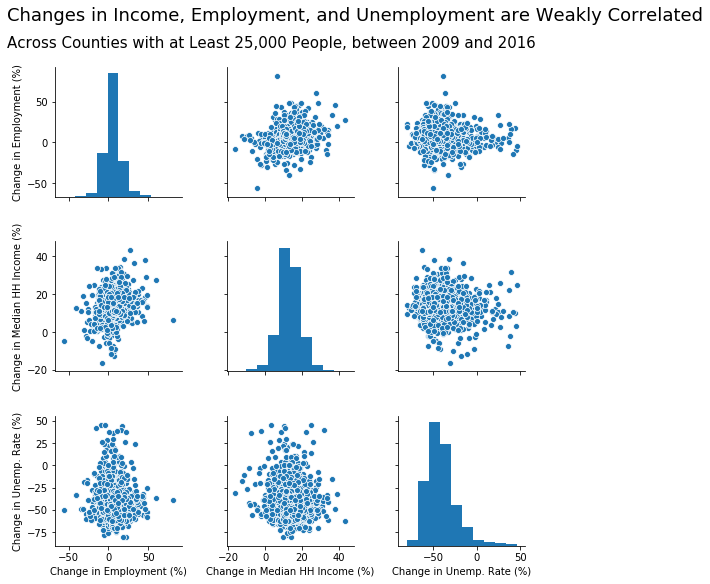

In [23]:
# Create pairwise scatterplot of our three dependent variables. 
pairwise_scatterplot = sns.pairplot(county_dataset[['Change in Employment (%)', 
                                                    'Change in Median HH Income (%)', 
                                                    'Change in Unemp. Rate (%)']])
pairwise_scatterplot.fig.text(0, 1.05,'Changes in Income, Employment, and Unemployment are Weakly Correlated', fontsize=18)
pairwise_scatterplot.fig.text(0, 1,'Across Counties with at Least 25,000 People, between 2009 and 2016', fontsize=15)


In [24]:
# Regress each of the three dependent variables on the other two independent variables, one at a time, and 
# summarize to obtain results.

# First, define our list of dependent variables, and add a constant to this dataframe of dependent variables
list_dependent_vars = ['Change in Employment (%)', 'Change in Median HH Income (%)', 'Change in Unemp. Rate (%)']
dependent_vars_data = county_dataset[['Change in Employment (%)', 
                                    'Change in Median HH Income (%)', 
                                    'Change in Unemp. Rate (%)']]
dependent_vars_data = dependent_vars_data.copy()
dependent_vars_data['Constant'] = 1 

# Define a blank list to which we will add results of each regression
dep_var_reg_results = []

# Loop over each dependent variable one at a time, and summarize regression to obtain results
for dep_var in list_dependent_vars:
    # Define the independent vars as the 'dependent_vars_data' dataframe minus the dependent variable that 
    # we are looping over
    independent_vars_data = dependent_vars_data.drop(columns=[dep_var])
    # Run OLS regression of this variable on the other two variables, plus a constant
    model = sm.OLS(dependent_vars_data[[dep_var]], independent_vars_data)
    reg_results = model.fit()
    # Add these regression results as a new entry in the list created above
    dep_var_reg_results.append(reg_results)
    
print(summary_col(dep_var_reg_results, stars=True, float_format='%0.2f', info_dict={
        'N':lambda x: "{0:d}".format(int(x.nobs)),
        'R^2':lambda x: "{:.2f}".format(x.rsquared)
    }))


                               Change in Employment (%) Change in Median HH Income (%) Change in Unemp. Rate (%)
----------------------------------------------------------------------------------------------------------------
Change in Employment (%)                                0.13***                        -0.11***                 
                                                        (0.01)                         (0.04)                   
Change in Median HH Income (%) 0.39***                                                 -0.02                    
                               (0.04)                                                  (0.07)                   
Change in Unemp. Rate (%)      -0.04***                 -0.00                                                   
                               (0.02)                   (0.01)                                                  
Constant                       -1.14                    12.46***                       -40.23**

Overall, these regressions show that these three measures of economic performance have limited power in explaining each other. They are discussed in more detail in the main report.

# Part 3: Analysis

This section runs the analysis. Namely, for each dependent variable we run a linear regression and a decision tree to determine the most important variables. We first run linear regressions, then the decision trees. To assess the accuracy of our models, we first split up the data into training and test sets.

## Splitting Up Data

We split up the data into training and test sets. The training data is the data we use to fit our model. We then run these models on the test data to assess their accuracy. We use 80% of the data as the training set, and the remaining 20% as the test set. Additionally, we split up the dataset into the feature matrix (of predictor variables) and the response (the three dependent variables). 

In [25]:
# First, split up data into a set of predictors and response variables
county_dataset_predictors = county_dataset[['Median Household Income ($)', 'Unemployment Rate (%)',
                                            'Poverty Rate (%)', 'Pop. w/ College Degree (%)', 
                                            'Share of Employment in Manufacturing (%)',
                                            'Percent of Votes for Obama in 2008', 
                                            "Percent of State's Votes for Obama in 2008",
                                            "State's Tax Burden Rate",
                                            'Log(County Population)',
                                            'Log(County Employment)',
                                            'Log(County Population Density)']]
county_dataset_response = county_dataset[['Change in Employment (%)', 'Change in Median HH Income (%)', 
                                          'Change in Unemp. Rate (%)']]

# Split up data into training set (80% of observations) and test set (20% of observations)
features_train, features_test, response_train, response_test = \
    train_test_split(county_dataset_predictors, county_dataset_response, random_state = 1, test_size = 0.2)


## Linear Regression

We run linear regressions with each dependent variable, one at a time, on the set of response variables. We use standardized coefficients to assess the magnitude of importance of each variable, and p-values to assess statistical significance. The first step is to standardize each variable in both our feature matrix and our responses.

In [26]:
# Define a function used to standardize a dataframe, by de-meaning each variable and dividing by its standard
# deviation.
def standardize_dataframe(df):
    '''
    This function has one input, which should be a pandas DataFrame consisting solely of numeric columns.
    An error message will be returned if a column is non-numeric.
    This function standardizes each variable (column) in the dataframe by subtracting the mean
    from each variable and dividing by its standard deviation.
    '''
    # Create a copy of the user-provided dataframe
    normalized_df = df.copy()
    # Loop over columns in this dataframe, normalizing each column
    for column_name in df.columns:
        normalized_df[column_name] = (df[column_name] - df[column_name].mean()) / (df[column_name].std())
    return normalized_df

In [27]:
# Specify a linear regression model, including an intercept, which we will fit for each possible 
# dependent variable
linear_regression_model = LinearRegression(fit_intercept = True)

# Create a blank list to which we will append a summary of our regression results
stand_OLS_reg_results = []

# Loop over each dependent variable. Fit a model where we regress this standardized variable on the standardized
# feature matrix, using the training data, and including a constant. Note that we essentially have to fit the
# regression twice, once using the 'statsmodels' and once using the 'sklearn' package. This is because the 
# 'sklearn' package is necessary to apply our fitted model to the test dataset, to evaluate accuracy. On the 
# other hand, the 'statsmodels' package is necessary to produce summary tables that indicate regression 
# coefficients and significance levels.
for dep_var in list_dependent_vars:
    # Use the sklearn package to fit the regression on our training data
    linear_regression_model.fit(standardize_dataframe(features_train), 
                                standardize_dataframe(response_train[[dep_var]]))

    # "Score" this regression model on the test data, by calculating the R^2 and the RMSE
    print(f"R^2 on test data when {dep_var} is dependent variable is {round(linear_regression_model.score(standardize_dataframe(features_test), standardize_dataframe(response_test[[dep_var]])), 3)}.")
    OLS_predictions = linear_regression_model.predict(standardize_dataframe(features_test))
    print(f"RMSE on test data when {dep_var} is dependent variable is {round(np.sqrt(mean_squared_error(standardize_dataframe(response_test[[dep_var]]), OLS_predictions)), 3)}.")

    # Use the statesmodels package to run this same model. Note that we need to explicitly add a constant to 
    # this model, unlike in the sklearn package.
    standardized_response_train_with_constant = standardize_dataframe(features_train)
    standardized_response_train_with_constant['Constant'] = 1
    statslearn_lm_model = sm.OLS(standardize_dataframe(response_train[[dep_var]]),
                                 standardized_response_train_with_constant)
    reg_results = statslearn_lm_model.fit()
    
    # Add these regression results as a new entry in the list created above
    stand_OLS_reg_results.append(reg_results)
    
# Print sumary results from these regressions, adding the training R^2
print(summary_col(stand_OLS_reg_results, stars=True, float_format='%0.2f', info_dict={
        'N':lambda x: "{0:d}".format(int(x.nobs)),
        'Training R^2':lambda x: "{:.2f}".format(x.rsquared),
        'Note: All variables are standardized.' : 'test'
    }))

R^2 on test data when Change in Employment (%) is dependent variable is 0.136.
RMSE on test data when Change in Employment (%) is dependent variable is 0.928.
R^2 on test data when Change in Median HH Income (%) is dependent variable is 0.009.
RMSE on test data when Change in Median HH Income (%) is dependent variable is 0.994.
R^2 on test data when Change in Unemp. Rate (%) is dependent variable is 0.287.
RMSE on test data when Change in Unemp. Rate (%) is dependent variable is 0.843.

                                           Change in Employment (%) Change in Median HH Income (%) Change in Unemp. Rate (%)
----------------------------------------------------------------------------------------------------------------------------
Median Household Income ($)                0.04                     -0.39***                       0.11*                    
                                           (0.06)                   (0.07)                         (0.06)                   
Unemploy

The results of these regressions are discussed in more detail in the main report.

## Decision Tree

We create a decision tree for each dependent variable. Note that decision trees have one hyperparameter, the maximum tree depth. Thus, for each dependent variable we consider a maximum tree depth of between 1 and 10, and choose the depth that has the maximum accuracy on the test data. Once we have chosen this, we assess the accuracy of the decision tree on the test data, and also plot the variable importances and display the overall decision tree.

### Choosing Overall Depth

In [28]:
# Specify a maximum range of our regression tree depth, from 1 through 10, inclusive. We loop over these values
# to determine the optimal tree depth to use, based on accuracy on the test data.
tree_depth_range = np.arange(1,11)

# Create a blank dataframe to which we will store the R^2 and root mean squared error (RMSE) from the test data 
# for each model. 
tree_depth_dataframe = pd.DataFrame(tree_depth_range, columns = ['tree_depth'])

# Loop over values of the maximum tree depth, and each of our three dependent variables. In each case, fit the 
# regression tree to the training data, then score the model based on the test data.
for dep_var in list_dependent_vars:
    # Create two blank lists for the given dependent variable, one contains the R^2 and one contains the 
    # root mean squared error, as a function of the maximum tree depth
    list_r_squared = []
    list_rmse = []
    for tree_depth in tree_depth_range:        
        # Define our decision tree model. Note that all of our dependent variables are continuous, so we fit a regression
        # tree to our data.
        decision_tree_model = tree.DecisionTreeRegressor(random_state = 1, max_depth = tree_depth)
        
        # Fit the model to the training data, based on the given dependent variable
        decision_tree_model.fit(features_train, response_train[[dep_var]])
        
        # Calculate predictions of regression tree applied to test data
        decision_tree_predictions = decision_tree_model.predict(features_test)
        
        # Calculate the RMSE based off of the prediction, and store this value.
        decision_tree_RMSE = np.sqrt(mean_squared_error(response_test[[dep_var]], decision_tree_predictions))
        list_rmse.append(decision_tree_RMSE)
        
        # Score the decision tree model when applying it to the test data. This calculates the R^2. Store this
        # value.
        decision_tree_r_squared = decision_tree_model.score(features_test, response_test[[dep_var]])
        list_r_squared.append(decision_tree_r_squared)

    # Add columns containing the R^2 and RMSE for this given dependent variable
    tree_depth_dataframe[dep_var + ' R^2'] = list_r_squared
    tree_depth_dataframe[dep_var + ' RMSE'] = list_rmse
    
# Display this dataframe
tree_depth_dataframe


,tree_depth,Change in Employment (%) R^2,Change in Employment (%) RMSE,Change in Median HH Income (%) R^2,Change in Median HH Income (%) RMSE,Change in Unemp. Rate (%) R^2,Change in Unemp. Rate (%) RMSE
0,1,0.053030,11.890235,0.025219,6.124089,0.097250,13.831775
1,2,0.053023,11.890280,0.043955,6.064949,0.222494,12.836482
2,3,0.064713,11.816662,0.044180,6.064238,0.154138,13.388864
3,4,0.079942,11.720064,0.041306,6.073347,0.148064,13.436853
4,5,0.072412,11.767922,-0.055781,6.373457,0.211115,12.930073
5,6,0.055856,11.872479,-0.038660,6.321567,0.062229,14.097515
6,7,-0.023826,12.363327,-0.083239,6.455802,-0.089642,15.196234
7,8,-0.024838,12.369436,-0.266298,6.980009,-0.262986,16.360378
8,9,-0.112622,12.888313,-0.358681,7.230143,-0.294719,16.564631
9,10,-0.242064,13.617402,-0.336140,7.169915,-0.378607,17.092844


Next, we want to visualize how the $R^{2}$ and the RMSE change as a function of the tree depth in the test data, for each of our three dependent variables.

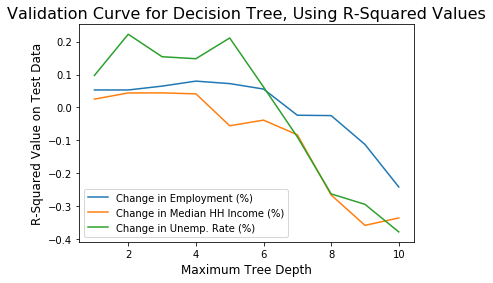

In [29]:
## This chunk of a code creates a validation curve for the R^2 values
val_curve_r_sq = plt.figure()
# Loop over each dependent variable and plot the R^2 values as a function of tree depth in the test data
for dep_var in list_dependent_vars:
    plt.plot(tree_depth_dataframe['tree_depth'], tree_depth_dataframe[dep_var + ' R^2'], label = dep_var)
# Add labels
plt.xlabel('Maximum Tree Depth', fontsize = 12)
plt.ylabel('R-Squared Value on Test Data', fontsize = 12)
plt.title('Validation Curve for Decision Tree, Using R-Squared Values', fontsize = 16)
plt.legend()
plt.show()


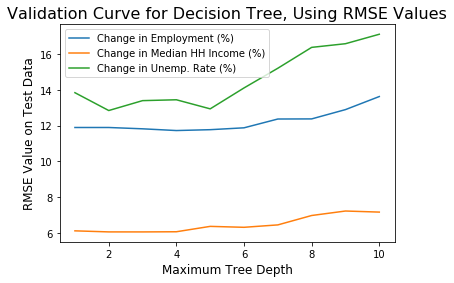

In [30]:
## This chunk of a code creates a validation curve for the RMSE values
val_curve_RMSE = plt.figure()
# Loop over each dependent variable and plot the RMSE values as a function of tree depth in the test data
for dep_var in list_dependent_vars:
    plt.plot(tree_depth_dataframe['tree_depth'], tree_depth_dataframe[dep_var + ' RMSE'], label = dep_var)
# Add labels
plt.xlabel('Maximum Tree Depth', fontsize = 12)
plt.ylabel('RMSE Value on Test Data', fontsize = 12)
plt.title('Validation Curve for Decision Tree, Using RMSE Values', fontsize = 16)
plt.legend()
plt.show()


The validation curves indicate that we should choose a maximum tree depth of 4 for changes in employment, 3 for changes in median household income, and 2 for changes in the unemployment rate. We use these tree depths to fit the models below and calculate the variable importances.

### Visualizing Trees and Calculating Variable Importances

The chunk of code below fit the decision trees with the corresponding depths determined above for each dependent variable, plot the variable importances, and visualizes the trees.

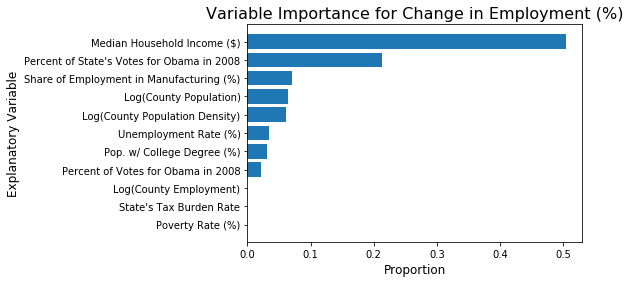

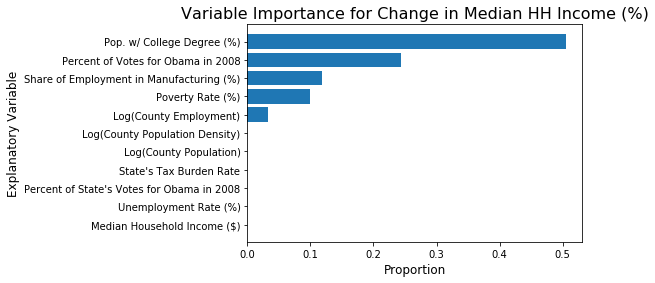

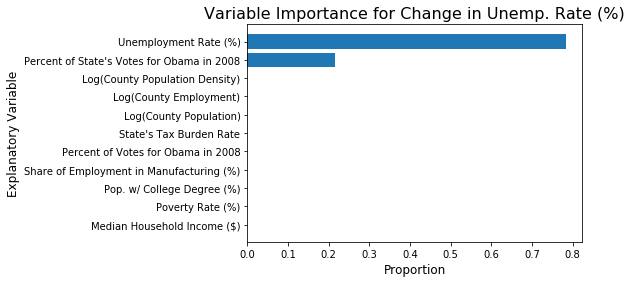

In [31]:
## This chunk of code fits a decision tree with the determined maximum tree depth to each dependent variable,
## plots the variable importances, and visualizes the regression tree.

# Loop over each of our dependent variables to fit the decision tree with the maximum tree depth determined above,
# plot the variable importances, and visualize the regression tree.
for dep_var in list_dependent_vars:
    # Determine the tree depth by locating the minimum value of the root mean squared error
    tree_depth_for_dep_var = tree_depth_dataframe.iloc[tree_depth_dataframe[dep_var + ' RMSE'].idxmin(), 0]
    
    # Fit the decision tree with this depth to the training data
    decision_tree_model = tree.DecisionTreeRegressor(random_state = 1, max_depth = tree_depth_for_dep_var)
        
    # Fit the model to the training data, based on the given dependent variable
    decision_tree_model.fit(features_train, response_train[[dep_var]])
    
    # Create a dataframe with the variable importances stored for each variable
    decision_tree_variable_importances = pd.DataFrame({'Variable': features_train.columns,
                                                       'Importance' : decision_tree_model.feature_importances_})
    decision_tree_variable_importances = decision_tree_variable_importances.sort_values(by='Importance')
    
    # Plot the variable importances
    plt.barh(decision_tree_variable_importances['Variable'], decision_tree_variable_importances['Importance'])
    plt.xlabel('Proportion', fontsize = 12)
    plt.ylabel('Explanatory Variable', fontsize = 12)
    plt.title('Variable Importance for ' + dep_var, fontsize = 16)
    plt.show()
    
    # Visualize the regression tree and export as a PDF
    file_name = 'Regression_Trees/' + dep_var + ' Regression Tree.pdf'
    reg_tree_dot_data = export_graphviz(decision_tree_model, out_file = None,
                                        feature_names = features_train.columns)
    reg_tree_graph = pydotplus.graph_from_dot_data(reg_tree_dot_data)
    reg_tree_graph.write_pdf(file_name)